**Name:** \_\_\_\_\_

**EID:** \_\_\_\_\_

# CS5495 - Tutorial 5
## CNNs - Feature Visualization

In this tutorial, you use feature visualization to examine the learned features in a CNN. 

First we need to initialize Python.  Run the below cell.

In [1]:
# setup
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100  # display larger images
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
pd.set_option('display.precision', 5)
import statsmodels.api as sm
import lime
import shap
from sklearn.model_selection import train_test_split
import os
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import torchvision

print(f"Using pytorch version: {torch.__version__}")

if (torch.cuda.is_available()):
    device = torch.device("cuda:0")
    print(f"Using: {torch.cuda.get_device_name(device)}")
elif (torch.backends.mps.is_available()):
    device = torch.device("mps")
    print(f"Using: Apple MPS")
else:
    raise("no GPU available")


Using pytorch version: 2.8.0+cu128
Using: Tesla T4


## Helper functions
- These are helper functions from the lecture

In [3]:
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            if titles is not None:
                if isinstance(titles, str): 
                    plt.title(titles % idx)
                else:
                    plt.title(titles[idx])
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()

## Dog vs Cat Dataset

The task is to classify an image as having a cat or a dog. This dataset is from [Kaggle](https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/data).

In our dataset Class `0` is cat, and class `1` is dog.

First let's load the validation images. Make sure you have unzipped the validation and model files into your directory.

In [4]:
# the transform of the data for input into the network
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
# class to store the dataset
class CatDogDataset(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform
        
    def __len__(self): return self.len
    
    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        label = 0 if 'cat' in path else 1
        return (image, label)

In [6]:
# collect validation data file names
img_files = os.listdir('valid/')
len(img_files)
img_files = list(filter(lambda x: x != 'valid', img_files))
def valid_path(p): return f"valid/{p}"
img_files = list(map(valid_path, img_files))[::10] # subsample to make it faster

In [7]:
# load the dataset
valid_ds = CatDogDataset(img_files, test_transform)
valid_dl = DataLoader(valid_ds, batch_size=100)
classnames = ['cat', 'dog']
len(valid_ds), len(valid_dl)

(500, 5)

Now let's view a few samples

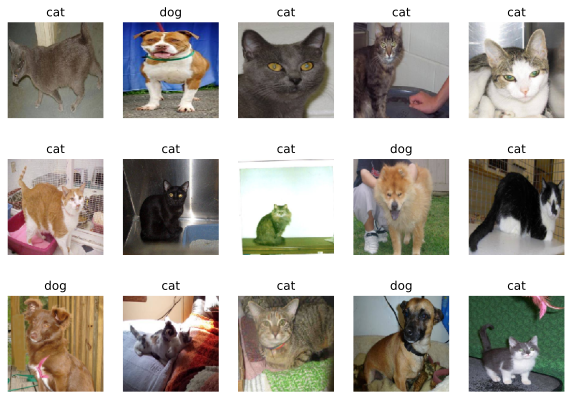

In [8]:
eg_imgs  = []
eg_names = []
for X,Y in valid_dl:
    for i in range(15):
        # transform the image from [-1,1] to [0,1]
        eg_imgs.append( (1+transpose(X[i], (1,2,0)))/2 )
        eg_names.append( classnames[Y[i]] )
    break
plt.figure(figsize=(10,7))
show_imgs(eg_imgs, titles=eg_names, nc=5)
plt.show()
plt.close()

# Deep CNNs

We have trained four Deep CNNs on the training set:

1. Model 1: 5 layers of convolutions, then global-average pooling and a linear classifier layer.
2. Model 2: 7 layers of convolutions, then global average pooling and a linear classifier layer.
3. Model 3: ResNet-18 (17 convolution layers), then global average pooling and a linear classifier layer. Trained from scratch.
4. Model 4: ResNet-18 (same as Model 3), but the network is initialized with pre-trained weights based on ImageNet.

Note that the global-average pooling takes the last convolution feature map (say C x H x W), and then averages over all the spatial nodes to obtain a (C x 1 x 1) feature vector. This is then used by the linear classifier layer.  Thus, the weights in the linear classifier layer will indicate which of the C feature channels was useful for the classification task.

Now we will load each model. If your GPU has limited memory, probably you should only load one model at a time.

## Model 1 (5 conv layers)

In [9]:
class CatAndDogNet4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=(5, 5), stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(5, 5), stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3, 3), padding=1)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=(3, 3), padding=1)
        self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=(3, 3), padding=1)
        self.gap   = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(in_features= 128, out_features=2)
        
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)
        
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)
        
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)

        X = F.relu(self.conv4(X))
        
        X = F.relu(self.conv5(X))

        X = self.gap(X)
        
        X = X.view(X.shape[0], -1)
        X = self.fc1(X)
        
        return X

In [10]:
# load model
model1 = CatAndDogNet4().to(device)
model1.load_state_dict(torch.load('models/model4-19.pth', map_location="cpu"))
model1.to(device).eval()
print(model1)

CatAndDogNet4(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=2, bias=True)
)


## Model 2 (7 conv layers)

In [11]:
class CatAndDogNet6(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=(5, 5), stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(5, 5), stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3, 3), padding=1)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=(3, 3), padding=1)
        self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=(3, 3), padding=1)
        self.conv6 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=(3, 3), padding=1)
        self.conv7 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=(3, 3), padding=1)
        self.gap   = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(in_features= 128, out_features=2)
        
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)
        
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)
        
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)

        X = F.relu(self.conv4(X))
        
        X = F.relu(self.conv5(X))

        X = F.relu(self.conv6(X))

        X = F.relu(self.conv7(X))
        
        X = self.gap(X)
        
        X = X.view(X.shape[0], -1)
        X = self.fc1(X)        
        return X

In [12]:
# load model
model2 = CatAndDogNet6().to(device)
model2.load_state_dict(torch.load('models/model6-19.pth', map_location="cpu"))
model2.to(device).eval()
print(model2)

CatAndDogNet6(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=2, bias=True)
)


## Model 3 (ResNet-18, from scratch)

In [13]:
model3 = models.resnet18().to(device)
in_feats = model3.fc.in_features
model3.fc = nn.Linear(in_feats, 2)
model3.load_state_dict(torch.load('models/model8-17.pth', map_location="cpu"))
model3.to(device).eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Model 4 (ResNet-18, pretrained on ImageNet)

In [14]:
model4 = models.resnet18().to(device)
in_feats = model4.fc.in_features
model4.fc = nn.Linear(in_feats, 2)
model4.load_state_dict(torch.load('models/model7-18.pth', map_location="cpu"))
model4.to(device).eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Evaluation
Now we will evaluate the models. First consolidate them.

In [15]:
all_models = {
    'CNN5': model1, 
    'CNN7': model2, 
    'ResNet18': model3,
    'ResNet18p': model4
}
modelnames = all_models.keys()

Evaluate each  model on the validation data.

In [16]:
# Evaluation
correct = {}
total = {}
for myname,mymodel in all_models.items():    
    mymodel.to(device).eval()
    correct[myname] = 0
    total[myname] = 0
    
with torch.no_grad():
    # for each validation batch
    for data, targets in valid_dl:
        print('.', end='', flush=True)                
        data, targets = data.to(device), targets.to(device)

        # test each model
        for myname,mymodel in all_models.items():    
            mymodel.to(device).eval()
            correct[myname] = 0
            total[myname] = 0
        
            outputs = mymodel(data)
            _, predicted = torch.max(outputs.data, 1)
            total[myname] += targets.size(0)
            correct[myname] += (predicted == targets).sum().item()

print("")
for myname in all_models.keys():    
    print(myname + f' Accuracy on valid set: {100 * correct[myname] / total[myname]:.2f}%')

.....
CNN5 Accuracy on valid set: 84.00%
CNN7 Accuracy on valid set: 77.00%
ResNet18 Accuracy on valid set: 90.00%
ResNet18p Accuracy on valid set: 97.00%


# Feature Visualization

Now, examine the features of each model using the feature visualization method. 

You can use the `lucent` toolbox. If it is not installed on your system, use the following command: `pip install torch-lucent`
On the CS JupyterLab, you can run this by opening a terminal tab. In Jupyter notebook, you can run the following "magic" command `!pip install torch-lucent`

In [17]:
!pip install torch-lucent

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'docopt' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'docopt'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13783 sha256=6237962bd656d1b4aa2d4802454ad4ff4e2830c43a6adad716193ec75222fffe
  Stored in directory: /home/jovyan/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built docopt
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [torch-lucent] [kornia]e]


## Features in the Last Conv Layer 

Perform feature visualization on the last convolutional layer of the networks.  Since there are a lot of features, one suggestion is to focus on those features that were more useful for the classifier (e.g., looking at the features with largest effects).

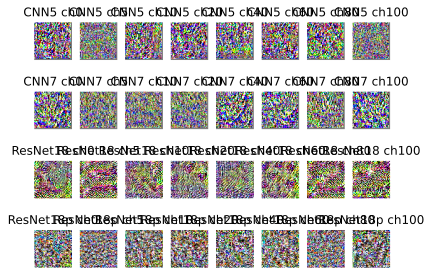

In [20]:
# Feature visualization (fixed): visualize filters in the last conv layer of each model.
# Fixes applied:
#  - ensure the optimized image is a true leaf tensor by creating it with requires_grad=True
#    and scaling it in-place inside torch.no_grad()
#  - create dummy inputs on the model's device when probing activation shapes
#  - robust error handling and useful diagnostic messages

import torch
from torch import optim
import torch.nn.functional as F

def get_activation_hook(store):
    def hook(module, input, output):
        store['act'] = output
    return hook

def tv_loss(img):
    b, c, h, w = img.shape
    tv = torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]))
    tv = tv + torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
    return tv

def visualize_filter(model, layer, channel, img_size=128, steps=40, lr=0.2,
                     l2_reg=1e-3, tv_reg=1e-4, device=torch.device('cpu')):
    """
    Optimize an input image (leaf tensor) to maximize mean activation of `channel` at `layer`.
    Returns an HxWxC numpy image in [0,1].
    """
    model.eval()
    store = {}
    handle = layer.register_forward_hook(get_activation_hook(store))

    # Create a true leaf tensor on the model device
    img = torch.randn(1, 3, img_size, img_size, device=device, requires_grad=True)
    # Scale the leaf in-place under no_grad to keep it a leaf
    with torch.no_grad():
        img.mul_(0.1)

    opt = optim.Adam([img], lr=lr)

    for i in range(steps):
        opt.zero_grad()
        try:
            _ = model(img)
        except Exception as e:
            handle.remove()
            raise RuntimeError(f"Model forward failed during visualization: {e}")
        act = store.get('act')
        if act is None:
            handle.remove()
            raise RuntimeError("Activation not captured. Check the layer argument.")
        loss = - act[0, channel].mean()  # maximize mean activation
        # regularizers
        loss = loss + l2_reg * (img**2).mean() + tv_reg * tv_loss(img)
        loss.backward()
        opt.step()
        # small clipping for stability
        with torch.no_grad():
            img.clamp_(-1.5, 1.5)
    handle.remove()

    # Convert to numpy [0,1]
    with torch.no_grad():
        out = img.detach().cpu().squeeze(0)
        out_min, out_max = out.min(), out.max()
        out = (out - out_min) / (out_max - out_min + 1e-8)
        out = out.permute(1,2,0).numpy()
    return out

# Channel selection (trim if layer has fewer channels)
channels_to_show = [0, 5, 10, 20, 40, 60, 80, 100]

# Decide which layer is the 'last conv' per model
last_layers = {}
for name, m in all_models.items():
    if hasattr(m, 'conv7'):
        last_layers[name] = m.conv7
    elif hasattr(m, 'conv5'):
        last_layers[name] = m.conv5
    else:
        # try ResNet-like assumption
        try:
            last_layers[name] = m.layer4[-1].conv2
        except Exception:
            last_layers[name] = m  # fallback (may give activations from whole model)

fig_images = []
fig_titles = []

for name, m in all_models.items():
    layer = last_layers.get(name)
    # model device
    try:
        model_device = next(m.parameters()).device
    except StopIteration:
        model_device = torch.device('cpu')
    # infer channel count by a dummy forward on same device
    try:
        st = {}
        h = layer.register_forward_hook(get_activation_hook(st))
        dummy = torch.zeros(1,3,64,64, device=model_device)
        _ = m(dummy)
        h.remove()
        C = st['act'].shape[1]
    except Exception:
        C = 128
    sel_channels = [ch for ch in channels_to_show if ch < C]
    for ch in sel_channels:
        try:
            vis = visualize_filter(m, layer, ch, img_size=128, steps=40, lr=0.15,
                                   l2_reg=1e-3, tv_reg=1e-4, device=model_device)
            fig_images.append(vis)
            fig_titles.append(f"{name} ch{ch}")
        except Exception as e:
            # print a concise diagnostic and continue
            print(f"Visualization failed for {name} ch{ch}: {e}")

if len(fig_images) > 0:
    show_imgs(fig_images, nc=8, titles=fig_titles)
else:
    print("No feature visualizations generated.")


## Summary of Feature Visualization

Provide a summary of your interpretation of the models using feature visualization. Some interesting questions to consider...
- Considering the four models, what types are features are extracted from the last conv layers?
- How do the features change with the depth of the model?
- How are the features different for models learned from scratch versus using a pre-trained initialization?
- how does the feature visualization help to understand the differences in validation set accuracy?


- **Summary of Feature Visualization (answers in English):**

  **Considering the four models, what types of features are extracted from the last conv layers?**  
  The last convolutional layers tend to capture higher-level textures and object parts rather than simple edges. For the shallow CNNs (CNN5 and CNN7) the last-layer visualizations show repetitive texture-like patterns and blob-like structures that emphasize class-discriminative textures (fur patterns, coarse shapes). For the deeper ResNet models the last-layer visualizations are more structured and often resemble object parts or combinations of edges and textures (curved contours, paws/ears-like shapes), indicating richer, more abstract features.

  **How do the features change with the depth of the model?**  
  Early layers (not shown here) generally extract low-level primitives such as edges, color blobs and simple oriented gradients. As depth increases, features become progressively more complex: mid-level layers combine edges into motifs and textures, and late layers represent larger motifs and object parts. The deeper the network, the more the filters in later layers encode complex, higher-level structures and combinations of lower-level patterns.

  **How are the features different for models learned from scratch versus using a pre-trained initialization?**  
  Models trained from scratch on a relatively small dataset often learn features that are strongly specialized to the training data (repeating dataset-specific textures or artifacts). Pre-trained models (e.g., ResNet initialized from ImageNet) bring richer, more natural features — the filters often encode common visual primitives and object-part detectors learned from a large and diverse dataset, leading to cleaner, more transferable, and semantically meaningful visualizations in later layers.

  **How does the feature visualization help to understand the differences in validation set accuracy?**  
  Feature visualization provides qualitative insight into what the network "looks for" when making decisions. Models whose late-layer filters show diverse, structured, and semantically meaningful patterns typically generalize better and often have higher validation accuracy. In contrast, models whose filters show noisy or highly repetitive simple textures may be overfitting or lacking capacity to capture discriminative object parts, which corresponds to lower validation performance. Therefore, visualizing learned features can help explain why one model performs better than another by revealing the complexity and usefulness of its internal representations.


# Art!

Now explore the feature visualizations of other parts of the network. See if you can find some interesting textures or patterns. What do they resemble?

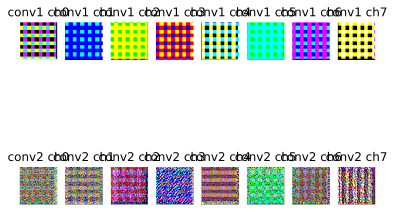

In [21]:
# "Art!" — visualize filters from earlier layers (conv1 and conv2)
# This uses the same stable visualize_filter function above.

import torch

def visualize_layers_for_model(model, layer_list, channels_per_layer=[0,1,2,3,4,5,6,7], img_size=128):
    imgs = []
    titles = []
    # determine model device
    try:
        model_device = next(model.parameters()).device
    except StopIteration:
        model_device = torch.device('cpu')
    for lname, layer in layer_list:
        try:
            st = {}
            h = layer.register_forward_hook(get_activation_hook(st))
            dummy = torch.randn(1,3,64,64, device=model_device)
            _ = model(dummy)
            h.remove()
            C = st['act'].shape[1]
        except Exception:
            C = 64
        sel = [ch for ch in channels_per_layer if ch < C]
        for ch in sel:
            try:
                vis = visualize_filter(model, layer, ch, img_size=img_size, steps=30, lr=0.18,
                                       l2_reg=1e-3, tv_reg=1e-4, device=model_device)
                imgs.append(vis)
                titles.append(f"{lname} ch{ch}")
            except Exception as e:
                print("Failed to visualize", lname, ch, e)
    return imgs, titles

# Choose a CNN with conv1/conv2 (fallback to the first available model)
target_model = None
for name, m in all_models.items():
    if hasattr(m, 'conv1') and hasattr(m, 'conv2'):
        target_model = m
        target_name = name
        break
if target_model is None:
    target_name = list(all_models.keys())[0]
    target_model = all_models[target_name]

# Build layer list
if hasattr(target_model, 'conv1') and hasattr(target_model, 'conv2'):
    layer_list = [('conv1', target_model.conv1), ('conv2', target_model.conv2)]
else:
    try:
        layer_list = [('layer1.0.conv1', target_model.layer1[0].conv1),
                      ('layer1.0.conv2', target_model.layer1[0].conv2)]
    except Exception:
        layer_list = []

imgs, titles = visualize_layers_for_model(target_model, layer_list, channels_per_layer=[0,1,2,3,4,5,6,7], img_size=96)
if imgs:
    show_imgs(imgs, nc=8, titles=titles)
else:
    print("No intermediate-layer visualizations produced.")
